In [1]:
import pandas as pd
import numpy as np
import cv2
import IPython.display as ipd
import librosa
import ndjson
import os

In [2]:
EMOTION_MAP = {
    '01': 'neutral',
    '02': 'neutral', # Calm = Neutral
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear',
    '07': 'disgust',
    '08': 'surprised'
}

In [3]:
import mediapipe as mp

casc_path = (r"C:\\Users\\PC\\anaconda3\\pkgs\\opencv-4.12.0-py312h6fcf9f4_0\\Library\\etc\\haarcascades\\haarcascade_frontalface_default.xml")

class EmotionFeatureExtractor:
    def __init__(self):
        self.mp_face_mesh = mp.solutions.face_mesh
        
        # --- CONFIGURATION FOR LINEAR TRACKING ---
        self.face_mesh = self.mp_face_mesh.FaceMesh(
            static_image_mode=False,        # FALSE = Enable Linear Tracking (Faster & Smoother)
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5     # Tracking needs this to be balanced
        )

    def reset(self):
        self.face_mesh.reset()

    def get_features(self, frame):
        # 1. Convert to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # 2. Process (Updates the internal tracker)
        results = self.face_mesh.process(rgb_frame)
        
        if not results.multi_face_landmarks:
            return None
        
        landmarks = results.multi_face_landmarks[0]
        
        # 3. Extract & Normalize (Same as before)
        coords = []
        for lm in landmarks.landmark:
            coords.append(lm.x)
            coords.append(lm.y)
        
        coords = np.array(coords).reshape(-1, 2)
        
        # Center & Scale
        nose_x, nose_y = coords[1] 
        coords[:, 0] -= nose_x
        coords[:, 1] -= nose_y
        
        dist = np.linalg.norm(coords[234] - coords[454]) + 1e-6
        coords /= dist
        
        return coords.flatten()

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [4]:
def process_video_dataset_kaggle():
    
    data_rows = []
    # Initialize Extractor (Make sure static_image_mode=False internally!)
    extractor = EmotionFeatureExtractor()
    
    ROOT_DIR = r"D:\Manager-angry-meter\kaggle-data\video"
    
    print(f"📂 Scanning recursive directories in: {ROOT_DIR}")

    for root, dirs, files in os.walk(ROOT_DIR):
        for filename in files:
            if filename.lower().endswith(('.mp4', '.avi')):
                
                # 1. Extract Label (Specific to Kaggle naming convention)
                try:
                    parts = filename.split('-')
                    if len(parts) >= 3:
                        code = parts[2]
                        emotion_label = EMOTION_MAP.get(code, 'unknown')
                    else:
                        emotion_label = 'unknown'
                except:
                    continue

                if emotion_label == 'unknown': continue

                video_path = os.path.join(root, filename)
                video_id = filename
                
                print(f"   Processing: {video_id} -> {emotion_label}")
                
                # --- LOGIC ALIGNMENT: RESET TRACKER ---
                extractor.reset()
                
                cap = cv2.VideoCapture(video_path)
                
                while True:
                    ret, frame = cap.read()
                    if not ret: break
                    
                    # --- LOGIC ALIGNMENT: PROCESS EVERY FRAME ---
                    features = extractor.get_features(frame)
                    
                    # --- LOGIC ALIGNMENT: SAVE EVERY VALID FRAME ---
                    if features is not None:
                        # Row: [ID, Label, Features...]
                        row = [video_id, emotion_label] + features.tolist()
                        data_rows.append(row)
                
                cap.release()

    return data_rows

# --- EXAMPLE USAGE TO BUILD DATAFRAME ---
# DATA_ROWS_KAGGLE = process_video_dataset_kaggle()

# if len(DATA_ROWS_KAGGLE) > 0:
#     num_features = len(DATA_ROWS_KAGGLE[0]) - 2  # Minus ID and Label
#     feature_cols = [f'pixel_{i}' for i in range(num_features)]
#     column_names = ['id', 'emotion'] + feature_cols 
    
#     df_kaggle = pd.DataFrame(DATA_ROWS_KAGGLE, columns=column_names)
#     print(f"✅ Kaggle Dataframe Shape: {df_kaggle.shape}")

In [5]:
CACHE_FILE_KAGGLE = "video_features_kaggle.pkl" # Unique name

if os.path.exists(CACHE_FILE_KAGGLE):
    print(f"🚀 Found '{CACHE_FILE_KAGGLE}'! Loading...")
    df_kaggle = pd.read_pickle(CACHE_FILE_KAGGLE)
else:
    print(f"🐢 Starting Kaggle Processing...")
    
    # 1. Run Extraction
    # Make sure you defined this function in the previous cell!
    DATA_ROWS = process_video_dataset_kaggle() 
    
    # 2. Safety Check
    if len(DATA_ROWS) > 0:
        # Kaggle rows = [ID, Emotion, Feat1, Feat2...] (Minus 2 columns)
        num_features = len(DATA_ROWS[0]) - 2 
        feature_cols = [f'pixel_{i}' for i in range(num_features)]
        column_names = ['id', 'emotion'] + feature_cols
        
        df_kaggle = pd.DataFrame(DATA_ROWS, columns=column_names)
        
        print("💾 Saving Kaggle data...")
        df_kaggle.to_pickle(CACHE_FILE_KAGGLE)
    else:
        print("❌ CRITICAL: No Kaggle data found. Check your ROOT_DIR path!")
        df_kaggle = pd.DataFrame()

print("\n✅ DONE.")
print(f"   Kaggle Shape:   {df_kaggle.shape}")

🚀 Found 'video_features_kaggle.pkl'! Loading...

✅ DONE.
   Kaggle Shape:   (53553, 958)


# audio dataframe

In [6]:
class AudioFeatureExtractor:
    def __init__(self):
        self.sample_rate = 22050
        
        # --- LOGIC UPDATE: Same as the improved extractor ---
        self.duration = 2.0  # Look at 2 seconds at a time (Context)
        self.step = 0.5      # Slide forward by 0.5 seconds (Overlap)
        self.n_mfcc = 40

    def get_features(self, audio_path):
        try:
            # 1. Load Audio
            y, sr = librosa.load(audio_path, sr=self.sample_rate)
            
            # 2. Trim Silence
            y_trimmed, _ = librosa.effects.trim(y, top_db=20)
            
            # If file was empty or pure silence, return nothing
            if len(y_trimmed) == 0:
                return []
            
            # Calculate samples needed
            window_samples = int(self.duration * sr)
            step_samples = int(self.step * sr)
            total_samples = len(y_trimmed)
            
            vectors = []
            
            # 3. SLIDING WINDOW LOGIC
            # If audio is shorter than 2s, we pad it.
            # If longer, we slide through it with overlap.
            
            if total_samples < window_samples:
                # Case A: Short Audio -> Pad with zeros
                padding_needed = window_samples - total_samples
                y_chunk = np.pad(y_trimmed, (0, padding_needed))
                vectors.append(self._extract_stats(y_chunk, sr))
            else:
                # Case B: Long Audio -> Slide Window
                # We add +1 to ensure we capture the final window if it fits exactly
                for start in range(0, total_samples - window_samples + 1, step_samples):
                    end = start + window_samples
                    chunk = y_trimmed[start:end]
                    
                    # Extract features for this window
                    vectors.append(self._extract_stats(chunk, sr))
                    
            return vectors

        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            return []

    def _extract_stats(self, y, sr):
        # --- LOGIC UPDATE: Rich Feature Set ---
        # (MFCC + Pitch + Roughness + Shouting)
        
        # 1. MFCC (Voice Texture)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc)
        
        # 2. Chroma (Pitch/Tonal content)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        
        # 3. Spectral Contrast (Roughness)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        
        # 4. Zero Crossing Rate (Noisiness/Shouting)
        zcr = librosa.feature.zero_crossing_rate(y)
        
        # --- AGGREGATE STATS (Mean & Std Dev) ---
        features = []
        
        # Add Mean and Std for all feature types
        for feat in [mfcc, chroma, contrast, zcr]:
            features.append(np.mean(feat, axis=1))
            features.append(np.std(feat, axis=1))
            
        # Flatten into one long vector
        return np.concatenate(features)

In [7]:
def process_audio_dataset():
    data_rows = []
    
    # Ensure you have your AudioFeatureExtractor class defined above!
    extractor = AudioFeatureExtractor() 
    
    # UPDATE THIS to your Kaggle Audio folder
    ROOT_DIR = r"D:\Manager-angry-meter\kaggle-data\audio"

    print(f"📂 Scanning recursive directories in: {ROOT_DIR}")
    print("✂️  Slicing audio files into segments...")

    # --- 1. USE OS.WALK (Recursive Search) ---
    for root, dirs, files in os.walk(ROOT_DIR):
        for filename in files:
            if filename.lower().endswith(('.wav', '.mp3', '.mp4')):
                
                # --- 2. EXTRACT EMOTION FROM FILENAME ---
                # Format: 03-01-05-01-01-01-01.wav
                try:
                    parts = filename.split('-')
                    if len(parts) >= 3:
                        code = parts[2]
                        emotion_label =EMOTION_MAP.get(code, 'unknown')
                    else:
                        emotion_label = 'unknown'
                except:
                    emotion_label = 'unknown'

                if emotion_label == 'unknown': continue

                file_path = os.path.join(root, filename)
                original_id = filename 

                # --- EXTRACT FEATURES ---
                # Returns list of vectors (one for each 0.5s chunk)
                chunk_list = extractor.get_features(file_path)
                
                if chunk_list:
                    for vector in chunk_list:
                        # --- 3. BUILD ROW WITH EMOTION ---
                        # Format: [ID, EMOTION, Feature_1, Feature_2...]
                        row = [original_id, emotion_label] + vector.tolist()
                        data_rows.append(row)

    print(f"✅ Processing Complete. Generated {len(data_rows)} total segments.")
    return data_rows

In [8]:
AUDIO_DATA_ROWS = process_audio_dataset()

if len(AUDIO_DATA_ROWS) > 0:
    # Calculate feature columns (Total length - 2 for 'id' and 'emotion')
    num_features = len(AUDIO_DATA_ROWS[0]) - 2
    
    feature_cols = [f'mfcc_{i}' for i in range(num_features)]
    
    # --- DEFINE COLUMNS EXPLICITLY ---
    column_names = ['id', 'emotion'] + feature_cols
    
    df_Audio = pd.DataFrame(AUDIO_DATA_ROWS, columns=column_names)
    
    print(f"\nExample of Segmented Data:")
    print(df_Audio.head())
    print(f"Total Segments: {len(df_Audio)}")
    print(f"Emotion Counts:\n{df_Audio['emotion'].value_counts()}")
else:
    print("❌ Error: No audio segments were generated. Check your ROOT_DIR.")

📂 Scanning recursive directories in: D:\Manager-angry-meter\kaggle-data\audio
✂️  Slicing audio files into segments...


c:\Users\PC\anaconda3\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


✅ Processing Complete. Generated 1207 total segments.

Example of Segmented Data:
                         id emotion      mfcc_0     mfcc_1     mfcc_2  \
0  01-01-05-01-01-01-01.wav   angry -402.956055  75.259445  -6.759887   
1  01-01-05-01-01-01-02.wav   angry -445.781647  70.724022 -22.633474   
2  01-01-05-01-01-01-03.wav   angry -476.068054  92.365135  10.084575   
3  01-01-05-01-01-01-04.wav   angry -446.963440  59.885502 -20.256659   
4  01-01-05-01-01-02-01.wav   angry -364.847107  69.648979  -7.049018   

      mfcc_3     mfcc_4     mfcc_5     mfcc_6     mfcc_7  ...   mfcc_110  \
0  19.964931  -5.159092  -6.579600  -7.443521   0.228306  ...  41.396125   
1   8.530368 -13.395951 -10.976827  -6.770191 -17.617781  ...  38.492131   
2  23.447985   3.723260  -8.903419 -12.500783  -8.851965  ...  42.313520   
3   5.426655 -17.499435 -12.566243 -12.518078 -23.689978  ...  39.316353   
4  16.514681 -10.613578  -7.778811 -11.969784 -11.818856  ...  43.166939   

   mfcc_111  mfcc_112 

# Train and Test Split

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

X=df_kaggle.drop(columns=['id','emotion'])
y=df_kaggle['emotion']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=df_kaggle['emotion']
)


In [10]:
X_audio=df_Audio.drop(columns=['id','emotion'])
y_audio=df_Audio['emotion']

scaler = StandardScaler()
X_scaled_audio = scaler.fit_transform(X_audio)

X_train_audio, X_test_audio, y_train_audio, y_test_audio = train_test_split(
    X_scaled_audio,
    y_audio,
    test_size=0.2,
    random_state=42,
    stratify=df_Audio['emotion']
)


# DECISION TREE

🌳 Tuning Decision Tree Depth...
   Depth 1: Train=0.27, Test=0.27
   Depth 3: Train=0.38, Test=0.38
   Depth 5: Train=0.50, Test=0.50
   Depth 7: Train=0.63, Test=0.63
   Depth 10: Train=0.79, Test=0.77
   Depth 15: Train=0.94, Test=0.90
   Depth 20: Train=0.99, Test=0.94


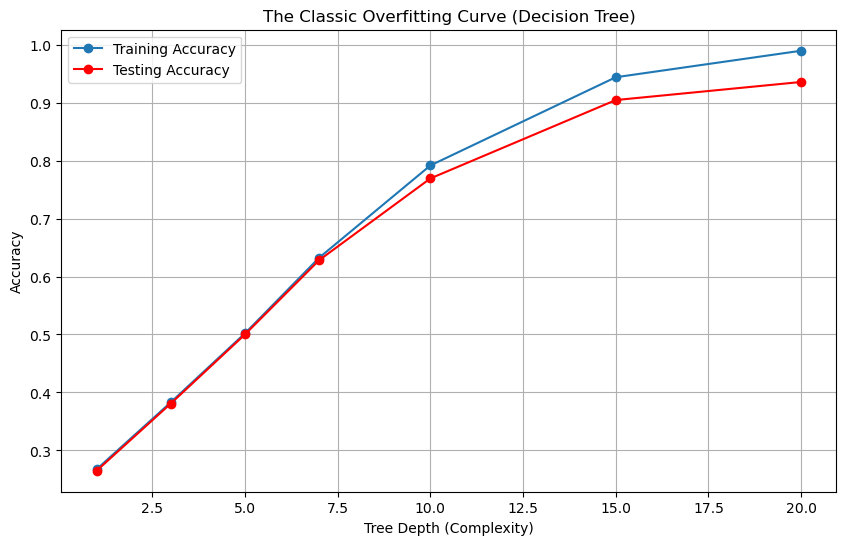

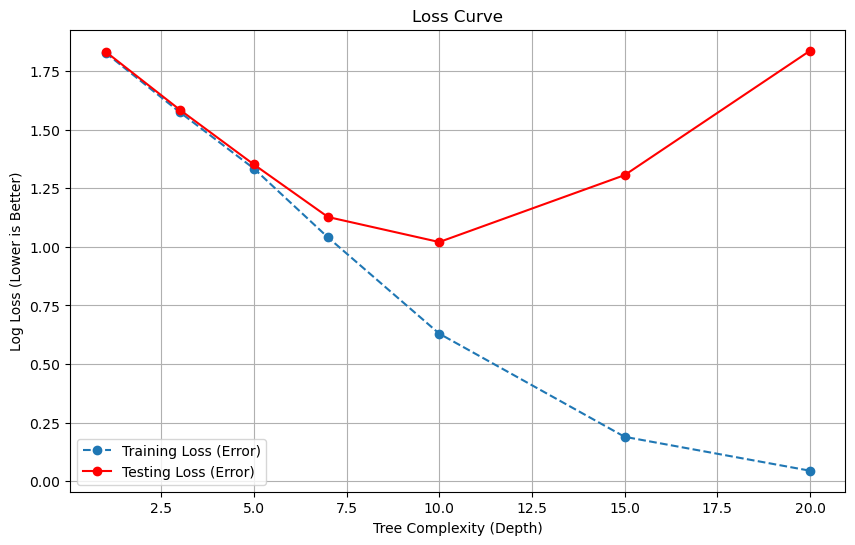

['video_model_DT.pkl']

In [11]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

# visualize loss
train_losses = []
test_losses = []
# Lists to store results
train_scores = []
test_scores = []
depths = [1, 3, 5, 7, 10, 15, 20]

print("🌳 Tuning Decision Tree Depth...")

best_acc = 0.0
best_model = None
best_depth = 0

for d in depths:
    # 1. Create Model with specific depth
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    
    # 2. Train
    clf.fit(X_train, y_train)
    
    # 3. Measure
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    
    y_train_probs = clf.predict_proba(X_train)
    y_test_probs = clf.predict_proba(X_test)

    loss_train = log_loss(y_train, y_train_probs)
    loss_test = log_loss(y_test, y_test_probs)

    train_losses.append(loss_train)
    test_losses.append(loss_test)

    train_scores.append(train_acc)
    test_scores.append(test_acc)
    
    print(f"   Depth {d}: Train={train_acc:.2f}, Test={test_acc:.2f}")

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = clf
        best_depth = d

# 4. PLOT THE "OVERFITTING" CURVE
plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, label='Training Accuracy', marker='o')
plt.plot(depths, test_scores, label='Testing Accuracy', marker='o', color='red')
plt.title('The Classic Overfitting Curve (Decision Tree)')
plt.xlabel('Tree Depth (Complexity)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Loss Curve

plt.figure(figsize=(10, 6))
plt.plot(depths, train_losses, label='Training Loss (Error)', marker='o', linestyle='--')
plt.plot(depths, test_losses, label='Testing Loss (Error)', marker='o', color='red')
plt.title('Loss Curve')
plt.xlabel('Tree Complexity (Depth)')
plt.ylabel('Log Loss (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()

filename = f"video_model_DT.pkl"
joblib.dump(best_model, filename)

In [12]:
# import matplotlib.pyplot as plt
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import log_loss

# # visualize loss
# train_losses = []
# test_losses = []
# # Lists to store results
# train_scores = []
# test_scores = []
# depths = [1, 3, 5, 7, 10, 15, 20, 30]

# print("🌳 Tuning Decision Tree Depth...")

# best_acc = 0.0
# best_model = None
# best_depth = 0

# for d in depths:
#     # 1. Create Model with specific depth
#     clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    
#     # 2. Train
#     clf.fit(X_train, y_train)
    
#     # 3. Measure
#     train_acc = accuracy_score(y_train, clf.predict(X_train))
#     test_acc = accuracy_score(y_test, clf.predict(X_test))
    
#     y_train_probs = clf.predict_proba(X_train)
#     y_test_probs = clf.predict_proba(X_test)

#     loss_train = log_loss(y_train, y_train_probs)
#     loss_test = log_loss(y_test, y_test_probs)

#     train_losses.append(loss_train)
#     test_losses.append(loss_test)

#     train_scores.append(train_acc)
#     test_scores.append(test_acc)
    
#     print(f"   Depth {d}: Train={train_acc:.2f}, Test={test_acc:.2f}")

#     if test_acc > best_acc:
#         best_acc = test_acc
#         best_model = clf
#         best_depth = d

# # 4. PLOT THE "OVERFITTING" CURVE
# plt.figure(figsize=(10, 6))
# plt.plot(depths, train_scores, label='Training Accuracy', marker='o')
# plt.plot(depths, test_scores, label='Testing Accuracy', marker='o', color='red')
# plt.title('The Classic Overfitting Curve (Decision Tree)')
# plt.xlabel('Tree Depth (Complexity)')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plotting Loss Curve

# plt.figure(figsize=(10, 6))
# plt.plot(depths, train_losses, label='Training Loss (Error)', marker='o', linestyle='--')
# plt.plot(depths, test_losses, label='Testing Loss (Error)', marker='o', color='red')
# plt.title('Loss Curve')
# plt.xlabel('Tree Complexity (Depth)')
# plt.ylabel('Log Loss (Lower is Better)')
# plt.legend()
# plt.grid(True)
# plt.show()

# filename = f"best_tree_depth_{best_depth}.pkl"
# joblib.dump(best_model, filename)
# print(f"✅ Best Model Saved: {filename} (Accuracy: {best_acc:.2%})")

🌳 Tuning Decision Tree Depth...
   Depth 1: Train=0.21, Test=0.21
   Depth 3: Train=0.24, Test=0.21
   Depth 5: Train=0.26, Test=0.23
   Depth 7: Train=0.30, Test=0.25
   Depth 10: Train=0.35, Test=0.25
   Depth 15: Train=0.37, Test=0.25
   Depth 20: Train=0.37, Test=0.25


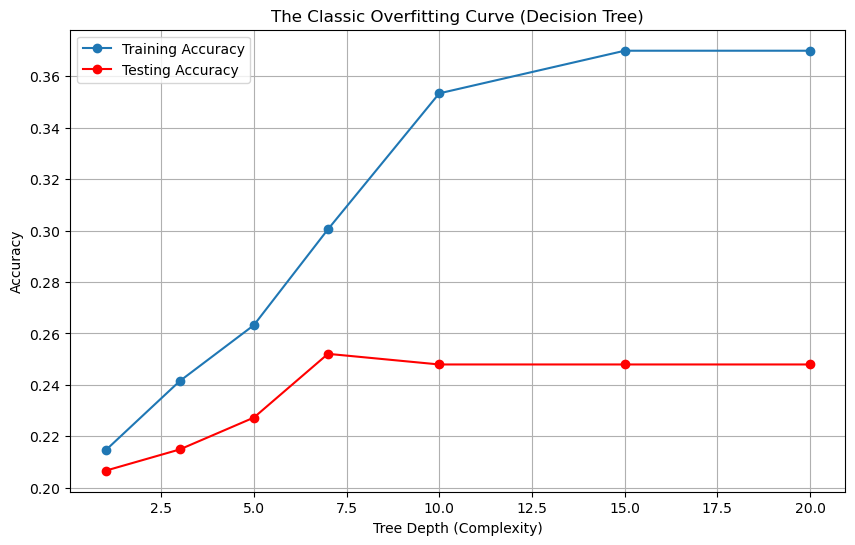

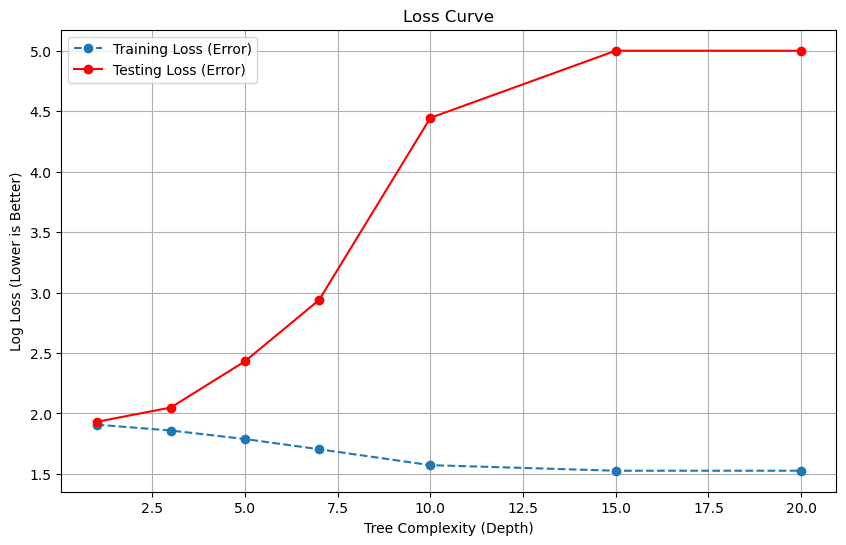

✅ Best Model Saved: audio_model_DT.pkl (Accuracy: 93.55%)


In [13]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

# visualize loss
train_losses_audio = []
test_losses_audio = []
# Lists to store results
train_scores_audio = []
test_scores_audio = []
depths_audio = [1, 3, 5, 7, 10, 15, 20]

best_acc = 0.0
best_model = None
best_depth = 0

print("🌳 Tuning Decision Tree Depth...")

for d in depths_audio:
    # 1. Create Model with specific depth
    clf_audio = DecisionTreeClassifier(max_depth=d, random_state=42)
    
    # 2. Train
    clf_audio.fit(X_train_audio, y_train_audio)
    
    # 3. Measure
    train_acc_audio = accuracy_score(y_train_audio, clf_audio.predict(X_train_audio))
    test_acc_audio = accuracy_score(y_test_audio, clf_audio.predict(X_test_audio))
    
    y_train_audio_probs = clf_audio.predict_proba(X_train_audio)
    y_test_probs_audio = clf_audio.predict_proba(X_test_audio)

    loss_train_audio = log_loss(y_train_audio, y_train_audio_probs)
    loss_test_audio = log_loss(y_test_audio, y_test_probs_audio)

    train_losses_audio.append(loss_train_audio)
    test_losses_audio.append(loss_test_audio)

    train_scores_audio.append(train_acc_audio)
    test_scores_audio.append(test_acc_audio)
    
    print(f"   Depth {d}: Train={train_acc_audio:.2f}, Test={test_acc_audio:.2f}")

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = clf
        best_depth = d

# 4. PLOT THE "OVERFITTING" CURVE
plt.figure(figsize=(10, 6))
plt.plot(depths_audio, train_scores_audio, label='Training Accuracy', marker='o')
plt.plot(depths_audio, test_scores_audio, label='Testing Accuracy', marker='o', color='red')
plt.title('The Classic Overfitting Curve (Decision Tree)')
plt.xlabel('Tree Depth (Complexity)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Loss Curve

plt.figure(figsize=(10, 6))
plt.plot(depths_audio, train_losses_audio, label='Training Loss (Error)', marker='o', linestyle='--')
plt.plot(depths_audio, test_losses_audio, label='Testing Loss (Error)', marker='o', color='red')
plt.title('Loss Curve')
plt.xlabel('Tree Complexity (Depth)')
plt.ylabel('Log Loss (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()

if best_model is not None:
    filename = f"audio_model_DT.pkl"
    joblib.dump(best_model, filename)
    print(f"✅ Best Model Saved: {filename} (Accuracy: {best_acc:.2%})")

In [14]:



# train_losses_audio = []
# test_losses_audio = []
# # Lists to store results
# train_scores_audio = []
# test_scores_audio = []
# depths_audio = [1, 3, 5, 7, 10, 15, 20, 30]

# best_acc = 0.0
# best_model = None
# best_depth = 0

# print("🌳 Tuning Decision Tree Depth...")

# for d in depths_audio:
#     # 1. Create Model with specific depth
#     reg_tree_audio = DecisionTreeClassifier(
#     max_depth= d, 
#     min_samples_leaf=10,  # <--- STRONG REGULARIZER
#     ccp_alpha=0.05,    # <--- PRUNING TO AVOID OVERFITTING
#     criterion='entropy',
#     random_state=42
# )
    
#     # 2. Train
#     reg_tree_audio.fit(X_train_audio, y_train_audio)
    
#     # 3. Measure
#     train_acc_audio = accuracy_score(y_train_audio, reg_tree_audio.predict(X_train_audio))
#     test_acc_audio = accuracy_score(y_test_audio, reg_tree_audio.predict(X_test_audio))
    
#     y_train_probs_audio = reg_tree_audio.predict_proba(X_train_audio)
#     y_test_probs_audio = reg_tree_audio.predict_proba(X_test_audio)

#     loss_train_audio = log_loss(y_train_audio, y_train_probs_audio)
#     loss_test_audio = log_loss(y_test_audio, y_test_probs_audio)

#     train_losses_audio.append(loss_train_audio)
#     test_losses_audio.append(loss_test_audio)

#     train_scores_audio.append(train_acc_audio)
#     test_scores_audio.append(test_acc_audio)
    
#     print(f"   Depth {d}: Train={train_acc_audio:.2f}, Test={test_acc_audio:.2f}")

#     if test_acc > best_acc:
#         best_acc = test_acc
#         best_model = clf
#         best_depth = d

# # 4. PLOT THE "OVERFITTING" CURVE
# plt.figure(figsize=(10, 6))
# plt.plot(depths_audio, train_scores_audio, label='Training Accuracy', marker='o')
# plt.plot(depths_audio, test_scores_audio, label='Testing Accuracy', marker='o', color='red')
# plt.title('The Classic Overfitting Curve (Decision Tree)')
# plt.xlabel('Tree Depth (Complexity)')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plotting Loss Curve

# plt.figure(figsize=(10, 6))
# plt.plot(depths_audio, train_losses_audio, label='Training Loss (Error)', marker='o', linestyle='--')
# plt.plot(depths_audio, test_losses_audio, label='Testing Loss (Error)', marker='o', color='red')
# plt.title('Loss Curve')
# plt.xlabel('Tree Complexity (Depth)')
# plt.ylabel('Log Loss (Lower is Better)')
# plt.legend()
# plt.grid(True)
# plt.show()


# KNN

🏷️ Class Mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
   (Note: Check which number 'Angry' is. You might need this for your App!)

📍 Tuning Normal KNN (Video)...
   k=1: Train Acc=1.00 | Test Acc=1.00 | Test Loss=0.06


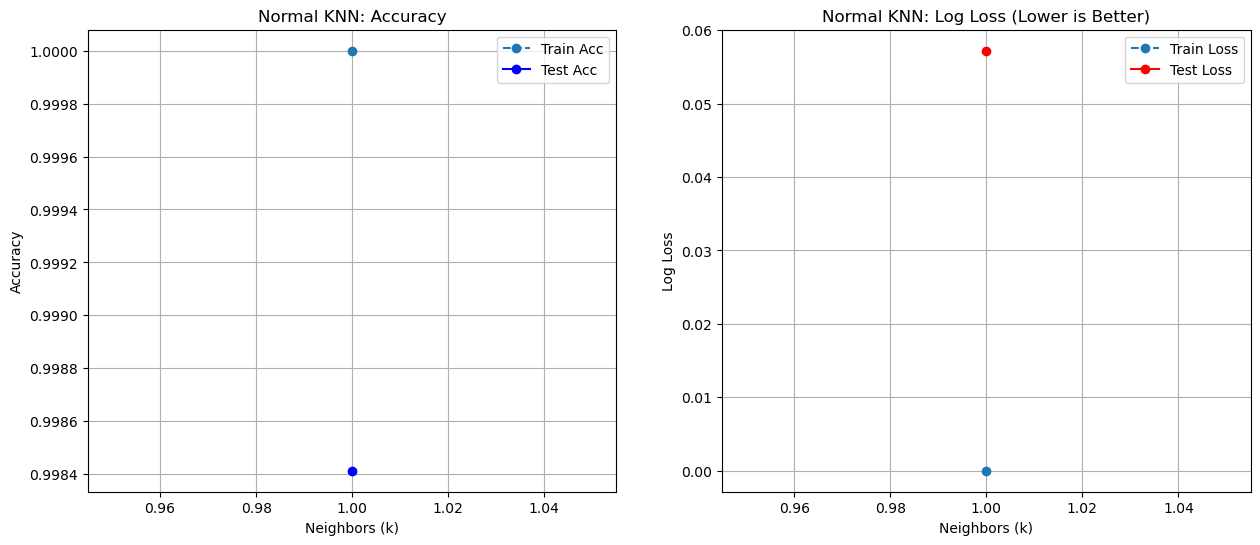

✅ Best Normal k: 1


['video_model_KNN.pkl']

In [15]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder


# --- 1. DATA FIX: ENCODE LABELS ---
# This converts 'angry', 'neutral' -> 0, 1 to prevent the ValueError
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("🏷️ Class Mapping:", dict(zip(le.classes_, range(len(le.classes_)))))
print("   (Note: Check which number 'Angry' is. You might need this for your App!)")

# --- 2. SETUP ---
neighbors = [1]

# Global lists to store results for Cell 2
global test_acc_normal, test_loss_normal
train_acc_normal, test_acc_normal = [], []
train_loss_normal, test_loss_normal = [], []

print("\n📍 Tuning Normal KNN (Video)...")

for k in neighbors:
    # NORMAL MODEL: Distance weights + Euclidean
    clf = KNeighborsClassifier(n_neighbors=k, weights='distance', p=2, n_jobs=-1)
    clf.fit(X_train, y_train_enc)
    
    # Calculate Probabilities for Log Loss
    y_probs_train = clf.predict_proba(X_train)
    y_probs_test = clf.predict_proba(X_test)
    
    # Store Metrics
    train_acc_normal.append(accuracy_score(y_train_enc, clf.predict(X_train)))
    test_acc_normal.append(accuracy_score(y_test_enc, clf.predict(X_test)))
    
    train_loss_normal.append(log_loss(y_train_enc, y_probs_train))
    test_loss_normal.append(log_loss(y_test_enc, y_probs_test))
    
    print(f"   k={k}: Train Acc={train_acc_normal[-1]:.2f} | Test Acc={test_acc_normal[-1]:.2f} | Test Loss={test_loss_normal[-1]:.2f}")

# --- PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy Plot
ax1.plot(neighbors, train_acc_normal, label='Train Acc', marker='o', linestyle='--')
ax1.plot(neighbors, test_acc_normal, label='Test Acc', marker='o', color='blue')
ax1.set_title('Normal KNN: Accuracy')
ax1.set_xlabel('Neighbors (k)')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss Plot
ax2.plot(neighbors, train_loss_normal, label='Train Loss', marker='o', linestyle='--')
ax2.plot(neighbors, test_loss_normal, label='Test Loss', marker='o', color='red')
ax2.set_title('Normal KNN: Log Loss (Lower is Better)')
ax2.set_xlabel('Neighbors (k)')
ax2.set_ylabel('Log Loss')
ax2.legend()
ax2.grid(True)

plt.show()

# Save Best Normal Model
best_idx = np.argmax(test_acc_normal)
print(f"✅ Best Normal k: {neighbors[best_idx]}")

# Save the encoder too, so we can decode '0' back to 'angry' later
joblib.dump(le, 'label_encoder.pkl') 

# Train and save best model
best_normal = KNeighborsClassifier(n_neighbors=neighbors[best_idx], weights='distance', n_jobs=-1)
best_normal.fit(X_train, y_train_enc)
joblib.dump(best_normal, 'video_model_KNN.pkl')

In [16]:
# # Check if Cell 1 was run
# if 'test_loss_normal' not in globals():
#     print("⚠️ STOP: Run Cell 1 first to define the data and normal scores!")
# else:
#     train_acc_robust = []
#     train_loss_robust = [] 
#     test_acc_robust = []
#     test_loss_robust = []
    
#     print("🛡️ Tuning Robust KNN (Video)...")

#     for k in neighbors:
#         # ROBUST MODEL: Uniform weights + Manhattan
#         # We use y_train_enc to avoid the ValueError
#         clf = KNeighborsClassifier(n_neighbors=k, weights='uniform', p=1, n_jobs=-1)
#         clf.fit(X_train, y_train_enc)
        
#         y_probs_test = clf.predict_proba(X_test)
        
#         # Store metrics
#         train_acc_robust.append(accuracy_score(y_train_enc, clf.predict(X_train)))
#         train_loss_robust.append(log_loss(y_train_enc, clf.predict_proba(X_train)))
#         test_acc_robust.append(accuracy_score(y_test_enc, clf.predict(X_test)))
#         test_loss_robust.append(log_loss(y_test_enc, y_probs_test))
        
#         # --- NEW: PRINT THE RESULTS ---
#         print(f"   k={k}: Train Acc={train_acc_robust[-1]:.2f} | Test Acc={test_acc_robust[-1]:.2f} | Test Loss={test_loss_robust[-1]:.2f}")

#     # --- COMPARISON PLOTS ---
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

#     # 1. ACCURACY COMPARISON
#     ax1.plot(neighbors, test_acc_normal, label='Normal (Distance)', marker='o', color='blue', alpha=0.5)
#     ax1.plot(neighbors, test_acc_robust, label='Robust (Uniform)', marker='s', color='green', linewidth=2)
#     ax1.plot(neighbors, train_acc_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
#     ax1.set_title('Accuracy: Normal vs Robust')
#     ax1.set_xlabel('Neighbors (k)')
#     ax1.set_ylabel('Test Accuracy')
#     ax1.legend()
#     ax1.grid(True)

#     # 2. LOSS COMPARISON
#     ax2.plot(neighbors, test_loss_normal, label='Normal (Distance)', marker='o', color='blue', alpha=0.5)
#     ax2.plot(neighbors, test_loss_robust, label='Robust (Uniform)', marker='s', color='green', linewidth=2)
#     ax2.plot(neighbors, train_loss_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
#     ax2.set_title('Log Loss: Normal vs Robust (Lower is Better)')
#     ax2.set_xlabel('Neighbors (k)')
#     ax2.set_ylabel('Log Loss')
#     ax2.legend()
#     ax2.grid(True)

#     plt.show()

#     # Save Best Robust Model
#     best_idx_r = np.argmax(test_acc_robust)
#     print(f"✅ Best Robust k: {neighbors[best_idx_r]}")
    
#     final_robust_model = KNeighborsClassifier(n_neighbors=neighbors[best_idx_r], weights='uniform', p=1, n_jobs=-1)
#     final_robust_model.fit(X_train, y_train_enc)

🎤 Audio Class Mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}

📍 Tuning Normal KNN (Audio)...
   k=1: Train Acc=0.31 | Test Acc=0.24 | Test Loss=27.26


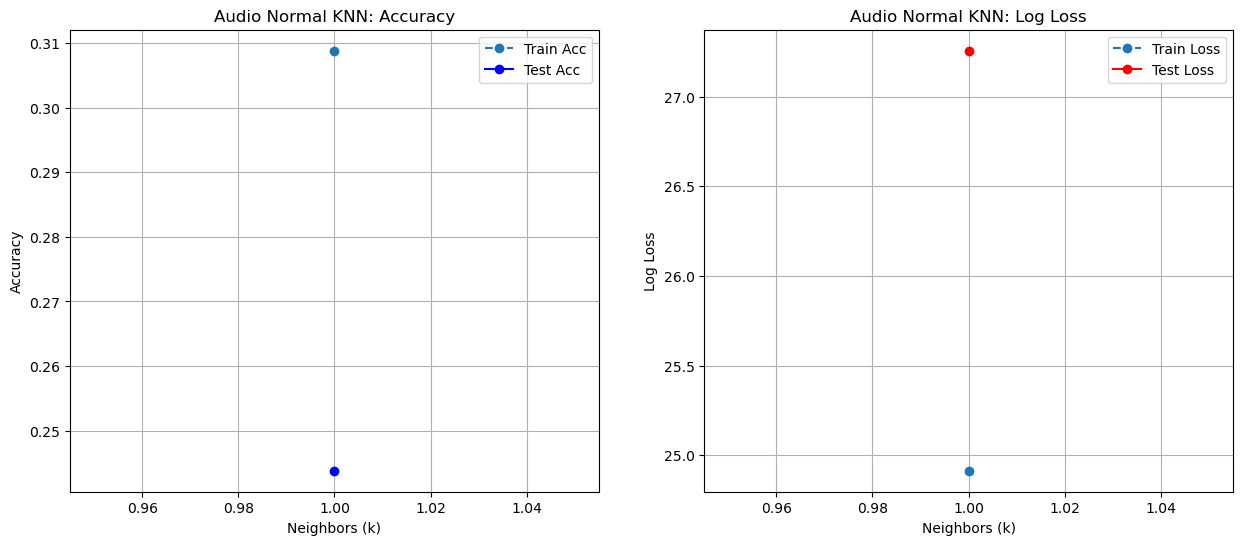

✅ Best Normal Audio k: 1


['audio_model_KNN.pkl']

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder

# --- 1. DATA FIX: ENCODE AUDIO LABELS ---
# We use a separate encoder for audio just in case the labels differ slightly
le_audio = LabelEncoder()
y_train_audio_enc = le_audio.fit_transform(y_train_audio)
y_test_audio_enc = le_audio.transform(y_test_audio)

print("🎤 Audio Class Mapping:", dict(zip(le_audio.classes_, range(len(le_audio.classes_)))))

# --- 2. SETUP ---
# Audio often needs slightly larger 'k' to smooth out noise
neighbors_audio = [1]

# Global lists for Cell 2
global test_acc_audio_normal, test_loss_audio_normal
train_acc_audio_normal, test_acc_audio_normal = [], []
train_loss_audio_normal, test_loss_audio_normal = [], []

print("\n📍 Tuning Normal KNN (Audio)...")

for k in neighbors_audio:
    # NORMAL MODEL: Distance weights + Euclidean
    clf = KNeighborsClassifier(n_neighbors=k, weights='distance', p=2, n_jobs=-1)
    clf.fit(X_train_audio, y_train_audio_enc)
    
    # Calculate Probabilities
    y_probs_train = clf.predict_proba(X_train_audio)
    y_probs_test = clf.predict_proba(X_test_audio)
    
    # Store Metrics
    train_acc_audio_normal.append(accuracy_score(y_train_audio_enc, clf.predict(X_train_audio)))
    test_acc_audio_normal.append(accuracy_score(y_test_audio_enc, clf.predict(X_test_audio)))
    
    train_loss_audio_normal.append(log_loss(y_train_audio_enc, y_probs_train))
    test_loss_audio_normal.append(log_loss(y_test_audio_enc, y_probs_test))
    
    print(f"   k={k}: Train Acc={train_acc_audio_normal[-1]:.2f} | Test Acc={test_acc_audio_normal[-1]:.2f} | Test Loss={test_loss_audio_normal[-1]:.2f}")

# --- PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy Plot
ax1.plot(neighbors_audio, train_acc_audio_normal, label='Train Acc', marker='o', linestyle='--')
ax1.plot(neighbors_audio, test_acc_audio_normal, label='Test Acc', marker='o', color='blue')
ax1.set_title('Audio Normal KNN: Accuracy')
ax1.set_xlabel('Neighbors (k)')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss Plot
ax2.plot(neighbors_audio, train_loss_audio_normal, label='Train Loss', marker='o', linestyle='--')
ax2.plot(neighbors_audio, test_loss_audio_normal, label='Test Loss', marker='o', color='red')
ax2.set_title('Audio Normal KNN: Log Loss')
ax2.set_xlabel('Neighbors (k)')
ax2.set_ylabel('Log Loss')
ax2.legend()
ax2.grid(True)

plt.show()

# Save Best Normal Model & Encoder
best_idx_a = np.argmax(test_acc_audio_normal)
print(f"✅ Best Normal Audio k: {neighbors_audio[best_idx_a]}")

joblib.dump(le_audio, 'label_encoder_audio.pkl') 

best_audio_normal = KNeighborsClassifier(n_neighbors=neighbors_audio[best_idx_a], weights='distance', n_jobs=-1)
best_audio_normal.fit(X_train_audio, y_train_audio_enc)
joblib.dump(best_audio_normal, 'audio_model_KNN.pkl')

In [18]:
# # Check if Cell 1 was run
# if 'test_loss_audio_normal' not in globals():
#     print("⚠️ STOP: Run Audio Cell 1 first!")
# else:
#     train_acc_audio_robust = []
#     test_acc_audio_robust = []
#     test_loss_audio_robust = []
    
#     print("🛡️ Tuning Robust KNN (Audio)...")

#     for k in neighbors_audio:
#         # ROBUST MODEL: Uniform weights + Manhattan
#         # Using encoded labels
#         clf = KNeighborsClassifier(n_neighbors=k, weights='uniform', p=1, n_jobs=-1)
#         clf.fit(X_train_audio, y_train_audio_enc)
        
#         y_probs_test = clf.predict_proba(X_test_audio)
        
#         # Store metrics
#         train_acc_audio_robust.append(accuracy_score(y_train_audio_enc, clf.predict(X_train_audio)))
#         test_acc_audio_robust.append(accuracy_score(y_test_audio_enc, clf.predict(X_test_audio)))
#         test_loss_audio_robust.append(log_loss(y_test_audio_enc, y_probs_test))
        
#         # --- PRINT THE RESULTS ---
#         print(f"   k={k}: Train Acc={train_acc_audio_robust[-1]:.2f} | Test Acc={test_acc_audio_robust[-1]:.2f} | Test Loss={test_loss_audio_robust[-1]:.2f}")

#     # --- COMPARISON PLOTS ---
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

#     # 1. ACCURACY COMPARISON
#     ax1.plot(neighbors_audio, train_acc_audio_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
#     ax1.plot(neighbors_audio, test_acc_audio_normal, label='Normal (Distance)', marker='o', color='blue', alpha=0.5)
#     ax1.plot(neighbors_audio, test_acc_audio_robust, label='Robust (Uniform)', marker='s', color='green', linewidth=2)
#     ax1.set_title('Audio Accuracy: Normal vs Robust')
#     ax1.set_xlabel('Neighbors (k)')
#     ax1.set_ylabel('Test Accuracy')
#     ax1.legend()
#     ax1.grid(True)

#     # 2. LOSS COMPARISON
#     ax2.plot(neighbors_audio, train_acc_audio_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
#     ax2.plot(neighbors_audio, test_loss_audio_normal, label='Normal (Distance)', marker='o', color='blue', alpha=0.5)
#     ax2.plot(neighbors_audio, test_loss_audio_robust, label='Robust (Uniform)', marker='s', color='green', linewidth=2)
#     ax2.set_title('Audio Log Loss: Normal vs Robust')
#     ax2.set_xlabel('Neighbors (k)')
#     ax2.set_ylabel('Log Loss')
#     ax2.legend()
#     ax2.grid(True)

#     plt.show()

#     # Save Best Robust Model
#     best_idx_ar = np.argmax(test_acc_audio_robust)
#     print(f"✅ Best Robust Audio k: {neighbors_audio[best_idx_ar]}")
    
#     final_robust_audio = KNeighborsClassifier(n_neighbors=neighbors_audio[best_idx_ar], weights='uniform', p=1, n_jobs=-1)
#     final_robust_audio.fit(X_train_audio, y_train_audio_enc)

# SVM

In [19]:

# from sklearn.svm import SVC


# # --- CONFIG ---
# # C values are usually logarithmic (powers of 10)
# c_values = [0.01, 0.1, 1, 10, 100]

# # Global lists to store results for Cell 2
# global test_acc_svm_normal, test_loss_svm_normal, train_acc_svm_normal
# train_acc_svm_normal, test_acc_svm_normal = [], []
# train_loss_svm_normal, test_loss_svm_normal = [], []

# print("📍 Tuning SVM C-Value (Video)...")

# for c in c_values:
#     # 1. Create Model 
#     # kernel='rbf' is standard for complex data like faces
#     # probability=True is REQUIRED for log_loss and the live app
#     clf = SVC(C=c, kernel='rbf', gamma='scale', probability=True, random_state=42)
    
#     # 2. Train
#     clf.fit(X_train, y_train)
    
#     # 3. Measure
#     # Predictions
#     y_pred_train = clf.predict(X_train)
#     y_pred_test = clf.predict(X_test)
#     y_probs_train = clf.predict_proba(X_train)
#     y_probs_test = clf.predict_proba(X_test)
    
#     # Store Metrics
#     train_acc_svm_normal.append(accuracy_score(y_train, y_pred_train))
#     test_acc_svm_normal.append(accuracy_score(y_test, y_pred_test))
    
#     train_loss_svm_normal.append(log_loss(y_train, y_probs_train))
#     test_loss_svm_normal.append(log_loss(y_test, y_probs_test))
    
#     print(f"   C={c}: Train Acc={train_acc_svm_normal[-1]:.2f} | Test Acc={test_acc_svm_normal[-1]:.2f} | Test Loss={test_loss_svm_normal[-1]:.2f}")

# # --- PLOTTING ---
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# # Accuracy Plot
# ax1.plot(c_values, train_acc_svm_normal, label='Train Acc', marker='o', linestyle='--')
# ax1.plot(c_values, test_acc_svm_normal, label='Test Acc', marker='o', color='blue')
# ax1.set_xscale('log') # Log scale for C
# ax1.set_title('SVM Tuning: Accuracy')
# ax1.set_xlabel('C Value (Regularization Inverse)')
# ax1.set_ylabel('Accuracy')
# ax1.legend()
# ax1.grid(True)

# # Loss Plot
# ax2.plot(c_values, train_loss_svm_normal, label='Train Loss', marker='o', linestyle='--')
# ax2.plot(c_values, test_loss_svm_normal, label='Test Loss', marker='o', color='red')
# ax2.set_xscale('log') # Log scale for C
# ax2.set_title('SVM Tuning: Log Loss')
# ax2.set_xlabel('C Value')
# ax2.set_ylabel('Log Loss')
# ax2.legend()
# ax2.grid(True)

# plt.show()

# # Save Best Model
# best_idx = np.argmax(test_acc_svm_normal)
# best_c = c_values[best_idx]
# print(f"✅ Best SVM C: {best_c}")

# final_svm = SVC(C=best_c, kernel='rbf', gamma='scale', probability=True, random_state=42)
# final_svm.fit(X_train, y_train)
# joblib.dump(final_svm, 'video_model_SVM.pkl')
# print("💾 Saved as 'svm_emotion_video_model.pkl'")

In [20]:
# # Check if Cell 1 was run
# if 'test_loss_svm_normal' not in globals():
#     print("⚠️ STOP: Run Cell 1 first!")
# else:
#     train_acc_svm_robust = []
#     test_acc_svm_robust = []
#     train_loss_svm_robust = []
#     test_loss_svm_robust = []
    
#     print("🛡️ Tuning Robust SVM (Gamma Regularization)...")

#     for c in c_values:
#         # ROBUST MODEL: 
#         # We use gamma=0.001 or 'auto' to force a smoother boundary (Regularization)
#         clf = SVC(C=c, kernel='rbf', gamma=0.01, probability=True, random_state=42)
#         clf.fit(X_train, y_train)
        
#         y_probs_train = clf.predict_proba(X_train)
#         y_probs_test = clf.predict_proba(X_test)
        
#         # Store metrics
#         train_acc_svm_robust.append(accuracy_score(y_train, clf.predict(X_train)))
#         test_acc_svm_robust.append(accuracy_score(y_test, clf.predict(X_test)))
        
#         train_loss_svm_robust.append(log_loss(y_train, y_probs_train))
#         test_loss_svm_robust.append(log_loss(y_test, y_probs_test))
        
#         print(f"   C={c}: Train Acc={train_acc_svm_robust[-1]:.2f} | Test Acc={test_acc_svm_robust[-1]:.2f} | Test Loss={test_loss_svm_robust[-1]:.2f}")

#     # --- COMPARISON PLOTS ---
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

#     # 1. ACCURACY COMPARISON
#     ax1.plot(c_values, test_acc_svm_normal, label='Normal (Gamma=Scale)', marker='o', color='blue', alpha=0.5)
#     ax1.plot(c_values, test_acc_svm_robust, label='Robust (Gamma=0.01)', marker='s', color='green', linewidth=2)
#     ax1.plot(c_values, train_acc_svm_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
#     ax1.plot(c_values, train_acc_svm_normal, label='Normal Train', marker='o', linestyle='--', color='blue', alpha=0.3)
    
#     ax1.set_xscale('log')
#     ax1.set_title('SVM Accuracy: Normal vs Robust')
#     ax1.set_xlabel('C Value')
#     ax1.set_ylabel('Accuracy')
#     ax1.legend()
#     ax1.grid(True)

#     # 2. LOSS COMPARISON
#     ax2.plot(c_values, test_loss_svm_normal, label='Normal (Gamma=Scale)', marker='o', color='blue', alpha=0.5)
#     ax2.plot(c_values, test_loss_svm_robust, label='Robust (Gamma=0.01)', marker='s', color='green', linewidth=2)
#     ax2.plot(c_values, train_loss_svm_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)

#     ax2.set_xscale('log')
#     ax2.set_title('SVM Loss: Normal vs Robust')
#     ax2.set_xlabel('C Value')
#     ax2.set_ylabel('Log Loss')
#     ax2.legend()
#     ax2.grid(True)

#     plt.show()

In [22]:
# # Global lists for Audio
# global test_acc_svm_audio_normal, test_loss_svm_audio_normal
# train_acc_svm_audio_normal, test_acc_svm_audio_normal = [], []
# train_loss_svm_audio_normal, test_loss_svm_audio_normal = [], []

# print("🎤 Tuning SVM C-Value (Audio)...")

# for c in c_values:
#     # Audio often benefits from slightly lower C to handle noise
#     clf = SVC(C=c, kernel='rbf', gamma='scale', probability=True, random_state=42)
#     clf.fit(X_train_audio, y_train_audio)
    
#     y_probs_train = clf.predict_proba(X_train_audio)
#     y_probs_test = clf.predict_proba(X_test_audio)
    
#     train_acc_svm_audio_normal.append(accuracy_score(y_train_audio, clf.predict(X_train_audio)))
#     test_acc_svm_audio_normal.append(accuracy_score(y_test_audio, clf.predict(X_test_audio)))
    
#     train_loss_svm_audio_normal.append(log_loss(y_train_audio, y_probs_train))
#     test_loss_svm_audio_normal.append(log_loss(y_test_audio, y_probs_test))
    
#     print(f"   C={c}: Train Acc={train_acc_svm_audio_normal[-1]:.2f} | Test Acc={test_acc_svm_audio_normal[-1]:.2f} | Test Loss={test_loss_svm_audio_normal[-1]:.2f}")

# # --- PLOTTING ---
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ax1.plot(c_values, train_acc_svm_audio_normal, label='Train Acc', marker='o', linestyle='--')
# ax1.plot(c_values, test_acc_svm_audio_normal, label='Test Acc', marker='o', color='blue')
# ax1.set_xscale('log')
# ax1.set_title('Audio SVM Tuning: Accuracy')
# ax1.legend()
# ax1.grid(True)

# ax2.plot(c_values, train_loss_svm_audio_normal, label='Train Loss', marker='o', linestyle='--')
# ax2.plot(c_values, test_loss_svm_audio_normal, label='Test Loss', marker='o', color='red')
# ax2.set_xscale('log')
# ax2.set_title('Audio SVM Tuning: Loss')
# ax2.legend()
# ax2.grid(True)

# plt.show()

# # Save Best Audio Model
# best_idx_a = np.argmax(test_acc_svm_audio_normal)
# best_c_a = c_values[best_idx_a]
# print(f"✅ Best Audio SVM C: {best_c_a}")

# final_svm_audio = SVC(C=best_c_a, kernel='rbf', gamma='scale', probability=True, random_state=42)
# final_svm_audio.fit(X_train_audio, y_train_audio)
# joblib.dump(final_svm_audio, 'audio_model_SVM.pkl')

In [23]:
# if 'test_loss_svm_audio_normal' not in globals():
#     print("⚠️ STOP: Run Audio Cell 1 first!")
# else:
#     train_acc_svm_audio_robust = []
#     test_acc_svm_audio_robust = []
#     train_loss_svm_audio_robust = []
#     test_loss_svm_audio_robust = []
    
#     print("🛡️ Tuning Robust Audio SVM...")

#     for c in c_values:
#         # ROBUST AUDIO: Gamma=0.01 provides smoothing for noisy audio features
#         clf = SVC(C=c, kernel='rbf', gamma=0.01, probability=True, random_state=42)
#         clf.fit(X_train_audio, y_train_audio)
        
#         y_probs_train = clf.predict_proba(X_train_audio)
#         y_probs_test = clf.predict_proba(X_test_audio)
        
#         train_acc_svm_audio_robust.append(accuracy_score(y_train_audio, clf.predict(X_train_audio)))
#         test_acc_svm_audio_robust.append(accuracy_score(y_test_audio, clf.predict(X_test_audio)))
        
#         train_loss_svm_audio_robust.append(log_loss(y_train_audio, y_probs_train))
#         test_loss_svm_audio_robust.append(log_loss(y_test_audio, y_probs_test))
        
#         print(f"   C={c}: Train Acc={train_acc_svm_audio_robust[-1]:.2f} | Test Acc={test_acc_svm_audio_robust[-1]:.2f} | Test Loss={test_loss_svm_audio_robust[-1]:.2f}")

#     # --- COMPARISON PLOTS ---
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

#     # Accuracy
#     ax1.plot(c_values, test_acc_svm_audio_normal, label='Normal (Gamma=Scale)', marker='o', color='blue', alpha=0.5)
#     ax1.plot(c_values, test_acc_svm_audio_robust, label='Robust (Gamma=0.01)', marker='s', color='green', linewidth=2)
#     ax1.plot(c_values, train_acc_svm_audio_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
#     ax1.plot(c_values, train_acc_svm_audio_normal, label='Normal Train', marker='o', linestyle='--', color='blue', alpha=0.3)
    
#     ax1.set_xscale('log')
#     ax1.set_title('Audio SVM Accuracy: Normal vs Robust')
#     ax1.legend()
#     ax1.grid(True)

#     # Loss
#     ax2.plot(c_values, test_loss_svm_audio_normal, label='Normal (Gamma=Scale)', marker='o', color='blue', alpha=0.5)
#     ax2.plot(c_values, test_loss_svm_audio_robust, label='Robust (Gamma=0.01)', marker='s', color='green', linewidth=2)
#     ax2.plot(c_values, train_loss_svm_audio_robust, label='Robust Train', marker='s', linestyle='--', color='green', alpha=0.5)
    
#     ax2.set_xscale('log')
#     ax2.set_title('Audio SVM Loss: Normal vs Robust')
#     ax2.legend()
#     ax2.grid(True)

#     plt.show()

# Naive-Bayes

In [50]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- 1. The Weighted Gaussian Naive Bayes Class ---
class WeightedGaussianNB(BaseEstimator, ClassifierMixin):
    def __init__(self, feature_weights=None, var_smoothing=1e-9):
        # Fixed typo: _init_ -> __init__
        self.feature_weights = feature_weights
        self.var_smoothing = var_smoothing

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        self.classes_ = np.unique(y)
        n_features = X.shape[1]

        self.class_prior = {}
        self.mean_ = {}
        self.var_ = {}

        if self.feature_weights is None:
            self.feature_weights_ = np.ones(n_features)
        else:
            self.feature_weights_ = np.asarray(self.feature_weights)

        for c in self.classes_:
            X_c = X[y == c]
            self.class_prior[c] = X_c.shape[0] / X.shape[0]
            self.mean_[c] = X_c.mean(axis=0)
            self.var_[c] = X_c.var(axis=0) + self.var_smoothing
        
        return self

    def _log_gaussian(self, X, mean, var):
        return -0.5 * (
            np.log(2 * np.pi * var) +
            ((X - mean) ** 2) / var
        )

    def predict_log_proba(self, X):
        X = np.asarray(X)
        log_probs = []

        for c in self.classes_:
            log_prior = np.log(self.class_prior[c])
            log_likelihood = self._log_gaussian(
                X, self.mean_[c], self.var_[c]
            )
            # Apply feature weights
            weighted_ll = log_likelihood * self.feature_weights_
            log_probs.append(log_prior + weighted_ll.sum(axis=1))

        return np.vstack(log_probs).T

    def predict(self, X):
        log_probs = self.predict_log_proba(X)
        return self.classes_[np.argmax(log_probs, axis=1)]

# --- 2. Data Preparation ---

# Define X and y from your dataframe
X = df_kaggle.drop(columns=['id','emotion'])
y = df_kaggle['emotion']

# Save feature names
video_feature_names = X.columns.tolist()
# joblib.dump(video_feature_names, 'video_feature_names.pkl')
# print(f"✅ Saved {len(video_feature_names)} video feature names to 'video_feature_names.pkl'")

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Using y directly is cleaner here
)

print(f"Data Split: Train={X_train.shape}, Test={X_test.shape}")

# --- 3. Training & Validation ---

# Calculate variances and base weights from Training Data
variances = np.var(X_train, axis=0)
# Inverse variance weighting: features with low variance (stable) get higher weight
base_weights = 1 / (variances + 1e-6)

# Baseline (Unweighted)
baseline_model = WeightedGaussianNB(feature_weights=None)
baseline_model.fit(X_train, y_train)
baseline_acc = accuracy_score(y_test, baseline_model.predict(X_test))
print(f"Baseline Unweighted Accuracy: {baseline_acc:.4f}")

# --- 4. Tuning Loop (Grid Search for Scale) ---

# Setup Tuning Range (Log Scale from 0.01 to 10)
scales = np.logspace(-2, 1, 6) 

# Storage for plotting
train_accs, test_accs = [], []
train_losses, test_losses = [], []

print("Starting tuning loop...")

for s in scales:
    # Scale the base weights
    w = s * base_weights
    
    # Initialize and Fit
    model = WeightedGaussianNB(feature_weights=w, var_smoothing=1e-8)
    model.fit(X_train, y_train)
    
    # --- Predictions (Train) ---
    y_pred_train = model.predict(X_train)
    y_prob_train = np.exp(model.predict_log_proba(X_train)) # Convert log_prob to prob
    
    train_accs.append(accuracy_score(y_train, y_pred_train))
    train_losses.append(log_loss(y_train, y_prob_train))
    
    # --- Predictions (Test) ---
    y_pred_test = model.predict(X_test)
    y_prob_test = np.exp(model.predict_log_proba(X_test))
    
    test_accs.append(accuracy_score(y_test, y_pred_test))
    test_losses.append(log_loss(y_test, y_prob_test))
    
    print(f"Scale {s:.2f}: Test Acc={test_accs[-1]:.4f}")

# --- 5. Visualization ---
plt.figure(figsize=(16, 6))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(scales, train_accs, marker='o', linestyle='--', label='Train Acc', color='#1f77b4') 
plt.plot(scales, test_accs, marker='o', linestyle='-',  label='Test Acc',  color='blue')
plt.xscale('log')
plt.xlabel('Scale Factor (Log Scale)')
plt.ylabel('Accuracy')
plt.title('Weighted GNB Tuning: Accuracy')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()

# Plot 2: Log Loss
plt.subplot(1, 2, 2)
plt.plot(scales, train_losses, marker='o', linestyle='--', label='Train Loss', color='#1f77b4') 
plt.plot(scales, test_losses,  marker='o', linestyle='-',  label='Test Loss',  color='red')     
plt.xscale('log')
plt.xlabel('Scale Factor (Log Scale)')
plt.ylabel('Log Loss')
plt.title('Weighted GNB Tuning: Log Loss')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

# --- 6. Save Best Model (Optional) ---
# Find best scale index
best_idx = np.argmax(test_accs)
best_scale = scales[best_idx]
best_weights = best_scale * base_weights

print(f"\n🏆 Best Scale: {best_scale:.4f} with Accuracy: {test_accs[best_idx]:.4f}")

# Retrain final model
final_gnb = WeightedGaussianNB(feature_weights=best_weights)
final_gnb.fit(X_train, y_train)

# Save
# joblib.dump(final_gnb, 'nb_emotion_video_model.pkl')
# print("✅ Saved best weighted model to 'nb_emotion_video_model.pkl'")

Data Split: Train=(42842, 956), Test=(10711, 956)
Baseline Unweighted Accuracy: 0.4092
Starting tuning loop...


C:\Users\PC\AppData\Local\Temp\ipykernel_18624\1970372230.py:125: RuntimeWarning: overflow encountered in exp
  y_prob_train = np.exp(model.predict_log_proba(X_train)) # Convert log_prob to prob


ValueError: Input contains infinity or a value too large for dtype('float64').

Audio Split: Train=(76, 96), Test=(19, 96)
🎤 Tuning Weighted Naive Bayes (Audio)...


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_p

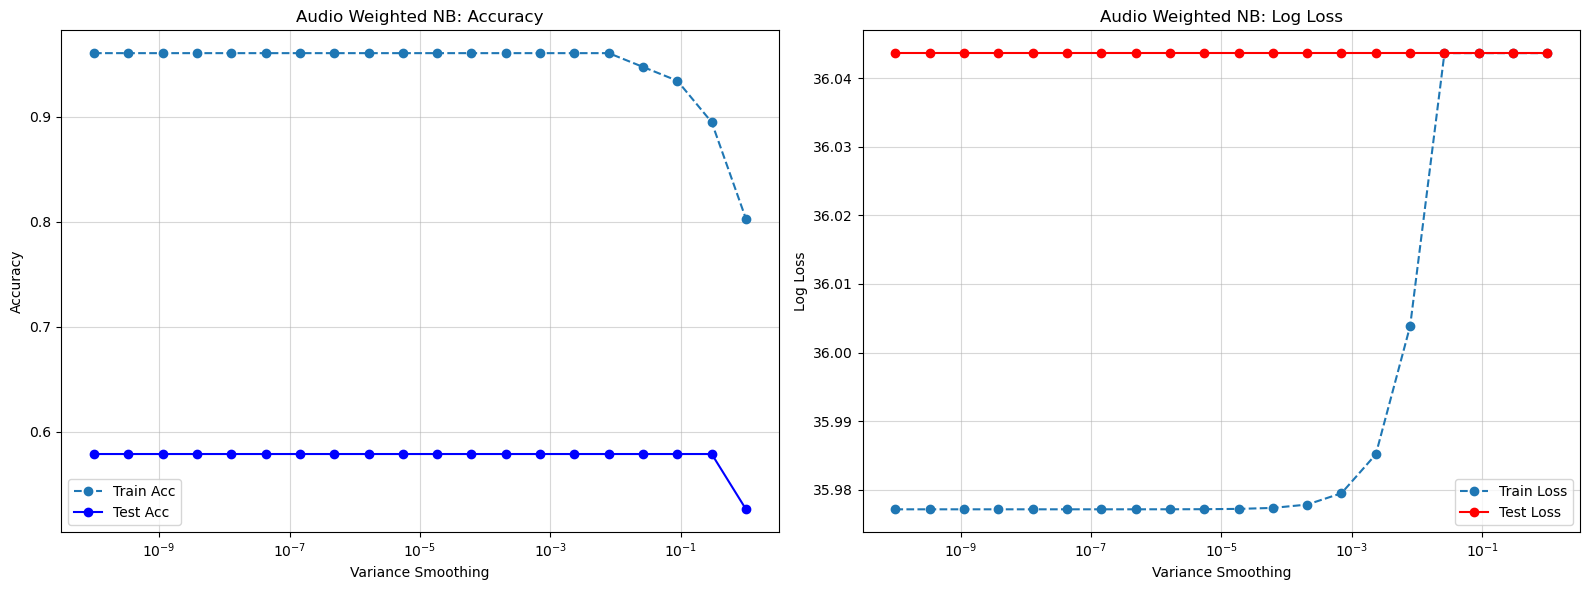

✅ Best Audio var_smoothing: 1.00e-10
   Best Test Accuracy: 0.5789


,feature_weights,array([1.1277... 0.94632117])
,var_smoothing,1e-10


In [ ]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- 1. The Weighted Gaussian NB Class ---
class WeightedGaussianNB(BaseEstimator, ClassifierMixin):
    def __init__(self, feature_weights=None, var_smoothing=1e-9):
        # Fixed typo: _init_ -> __init__
        self.feature_weights = feature_weights
        self.var_smoothing = var_smoothing

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.classes_ = np.unique(y)
        n_features = X.shape[1]

        self.class_prior = {}
        self.mean_ = {}
        self.var_ = {}

        if self.feature_weights is None:
            self.feature_weights_ = np.ones(n_features)
        else:
            self.feature_weights_ = np.asarray(self.feature_weights)

        for c in self.classes_:
            X_c = X[y == c]
            self.class_prior[c] = X_c.shape[0] / X.shape[0]
            self.mean_[c] = X_c.mean(axis=0)
            self.var_[c] = X_c.var(axis=0) + self.var_smoothing
        return self

    def _log_gaussian(self, X, mean, var):
        return -0.5 * (np.log(2 * np.pi * var) + ((X - mean) ** 2) / var)

    def predict_log_proba(self, X):
        X = np.asarray(X)
        log_probs = []
        for c in self.classes_:
            log_prior = np.log(self.class_prior[c])
            # Fixed call: self.log_gaussian -> self._log_gaussian
            log_likelihood = self._log_gaussian(X, self.mean_[c], self.var_[c])
            weighted_ll = log_likelihood * self.feature_weights_
            log_probs.append(log_prior + weighted_ll.sum(axis=1))
        return np.vstack(log_probs).T

    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))

    def predict(self, X):
        log_probs = self.predict_log_proba(X)
        return self.classes_[np.argmax(log_probs, axis=1)]

# --- 2. Data Preparation ---

# Define X and y from your dataframe
X_audio = df_Audio.drop(columns=['emotion'])
y_audio = df_Audio['emotion']

# Save audio feature names
audio_feature_names = X_audio.columns.tolist()
# joblib.dump(audio_feature_names, 'audio_feature_names.pkl')
# print(f"✅ Saved {len(audio_feature_names)} audio feature names to 'audio_feature_names.pkl'")

# Scale the data
scaler = StandardScaler()
X_scaled_audio = scaler.fit_transform(X_audio)

# Split with stratification
X_train_audio, X_test_audio, y_train_audio, y_test_audio = train_test_split(
    X_scaled_audio,
    y_audio,
    test_size=0.2,
    random_state=42,
    stratify=y_audio
)

print(f"Audio Split: Train={X_train_audio.shape}, Test={X_test_audio.shape}")

# --- 3. Weight Calculation & Tuning Setup ---

# Calculate weights based on Inverse Variance (Features with low variance are more reliable)
audio_variances = np.var(X_train_audio, axis=0)
audio_weights = 1 / (audio_variances + 1e-6)

# Define smoothing_values for the X-axis (Grid Search)
smoothing_values = np.logspace(-10, 0, 20) 

# Lists to store results
train_acc_nb_audio, test_acc_nb_audio = [], []
train_loss_nb_audio, test_loss_nb_audio = [], []

print("🎤 Tuning Weighted Naive Bayes (Audio)...")

# --- 4. Training Loop ---
for v in smoothing_values:
    # Use WeightedGaussianNB with the calculated weights
    clf_audio = WeightedGaussianNB(feature_weights=audio_weights, var_smoothing=v)
    clf_audio.fit(X_train_audio, y_train_audio)
    
    # Measure Performance
    y_probs_train = clf_audio.predict_proba(X_train_audio)
    y_probs_test = clf_audio.predict_proba(X_test_audio)
    
    train_acc_nb_audio.append(accuracy_score(y_train_audio, clf_audio.predict(X_train_audio)))
    test_acc_nb_audio.append(accuracy_score(y_test_audio, clf_audio.predict(X_test_audio)))
    
    train_loss_nb_audio.append(log_loss(y_train_audio, y_probs_train))
    test_loss_nb_audio.append(log_loss(y_test_audio, y_probs_test))

# --- 5. Visualization ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy Plot (Blue Theme)
ax1.plot(smoothing_values, train_acc_nb_audio, label='Train Acc', marker='o', linestyle='--', color='#1f77b4')
ax1.plot(smoothing_values, test_acc_nb_audio, label='Test Acc', marker='o', linestyle='-', color='blue')
ax1.set_xscale('log')
ax1.set_title('Audio Weighted NB: Accuracy')
ax1.set_xlabel('Variance Smoothing')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, which="both", ls="-", alpha=0.5)

# Loss Plot (Red Theme)
ax2.plot(smoothing_values, train_loss_nb_audio, label='Train Loss', marker='o', linestyle='--', color='#1f77b4')
ax2.plot(smoothing_values, test_loss_nb_audio, label='Test Loss', marker='o', linestyle='-', color='red')
ax2.set_xscale('log')
ax2.set_title('Audio Weighted NB: Log Loss')
ax2.set_xlabel('Variance Smoothing')
ax2.set_ylabel('Log Loss')
ax2.legend()
ax2.grid(True, which="both", ls="-", alpha=0.5)

plt.tight_layout()
plt.show()

# --- 6. Save Best Model ---
# Find best smoothing value based on Test Accuracy
best_idx_a = np.argmax(test_acc_nb_audio)
best_v_a = smoothing_values[best_idx_a]

print(f"✅ Best Audio var_smoothing: {best_v_a:.2e}")
print(f"   Best Test Accuracy: {test_acc_nb_audio[best_idx_a]:.4f}")

# Train final model with best smoothing AND weights
final_nb_audio = WeightedGaussianNB(feature_weights=audio_weights, var_smoothing=best_v_a)
final_nb_audio.fit(X_train_audio, y_train_audio)

# joblib.dump(final_nb_audio, 'nb_emotion_audio_model.pkl')
# print("💾 Saved best audio model as 'nb_emotion_audio_model.pkl'")

# Logistic Regression

c:\Users\PC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VIDEO | LR (no reg)
Accuracy: train=0.9744, test=0.9666
LogLoss : train=0.0811, test=0.0994


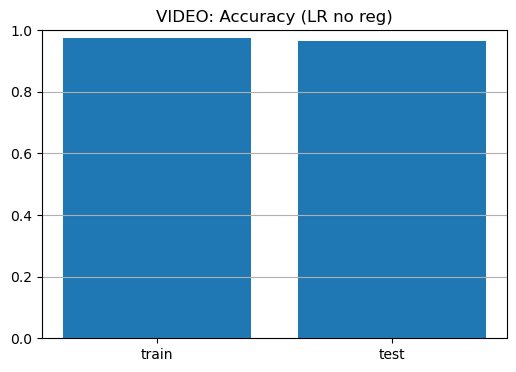

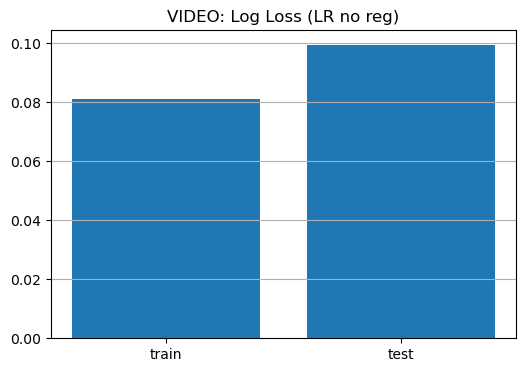

✅ Model saved successfully to: video_model_LR.pkl


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

video_plain = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        penalty=None,
        solver="lbfgs",
        max_iter=2500,
        random_state=42
    ))
])

video_plain.fit(X_train, y_train)

video_train_acc = accuracy_score(y_train, video_plain.predict(X_train))
video_test_acc  = accuracy_score(y_test,  video_plain.predict(X_test))

video_train_loss = log_loss(y_train, video_plain.predict_proba(X_train))
video_test_loss  = log_loss(y_test,  video_plain.predict_proba(X_test))

print("VIDEO | LR (no reg)")
print(f"Accuracy: train={video_train_acc:.4f}, test={video_test_acc:.4f}")
print(f"LogLoss : train={video_train_loss:.4f}, test={video_test_loss:.4f}")

plt.figure(figsize=(6,4))
plt.bar(["train","test"], [video_train_acc, video_test_acc])
plt.ylim(0,1)
plt.title("VIDEO: Accuracy (LR no reg)")
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(["train","test"], [video_train_loss, video_test_loss])
plt.title("VIDEO: Log Loss (LR no reg)")
plt.grid(axis="y")
plt.show()

model_filename = "video_model_LR.pkl"
joblib.dump(video_plain, model_filename)
print(f"✅ Model saved successfully to: {model_filename}")

In [27]:


# C_grid = np.logspace(-3, 3, 9)  # 1e-3 ... 1e3

# vid_train_accs, vid_test_accs = [], []
# vid_train_losses, vid_test_losses = [], []

# for C in C_grid:
#     video_l2 = Pipeline([
#         ("scaler", StandardScaler()),
#         ("lr", LogisticRegression(
#             penalty="l2",
#             C=float(C),
#             solver="lbfgs",
#             max_iter=2500,
#             random_state=42
#         ))
#     ])

#     video_l2.fit(X_train, y_train)

#     vid_train_accs.append(accuracy_score(y_train, video_l2.predict(X_train)))
#     vid_test_accs.append(accuracy_score(y_test,  video_l2.predict(X_test)))

#     vid_train_losses.append(log_loss(y_train, video_l2.predict_proba(X_train)))
#     vid_test_losses.append(log_loss(y_test,  video_l2.predict_proba(X_test)))

# best_idx = int(np.argmin(vid_test_losses))
# print("VIDEO | LR (L2)")
# print(f"Best C (lowest test log loss) = {C_grid[best_idx]:.4g}")
# print(f"Best test log loss = {vid_test_losses[best_idx]:.4f}")

# plt.figure(figsize=(8,5))
# plt.plot(C_grid, vid_train_accs, marker="o", label="train acc")
# plt.plot(C_grid, vid_test_accs, marker="o", label="test acc")
# plt.xscale("log")
# plt.xlabel("C (bigger = weaker regularization)")
# plt.ylabel("accuracy")
# plt.title("VIDEO: Accuracy vs C (LR L2)")
# plt.grid(True)
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,5))
# plt.plot(C_grid, vid_train_losses, marker="o", linestyle="--", label="train log loss")
# plt.plot(C_grid, vid_test_losses, marker="o", label="test log loss")
# plt.xscale("log")
# plt.xlabel("C (bigger = weaker regularization)")
# plt.ylabel("log loss (lower is better)")
# plt.title("VIDEO: Log Loss vs C (LR L2)")
# plt.grid(True)
# plt.legend()
# plt.show()


AUDIO | LR (no reg)
Accuracy: train=0.3699, test=0.2810
LogLoss : train=1.5266, test=3.7485


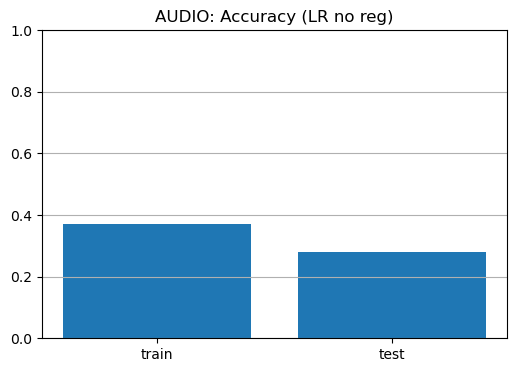

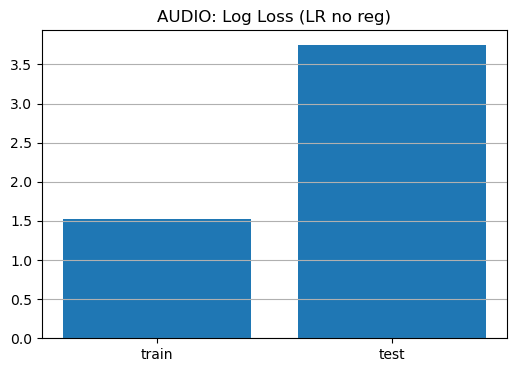

✅ Model saved successfully to: audio_model_LR.pkl


In [28]:
import joblib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# --- MODEL DEFINITION ---
audio_plain = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        penalty=None,
        solver="lbfgs",
        max_iter=2500,
        random_state=42
    ))
])

# --- TRAINING ---
audio_plain.fit(X_train_audio, y_train_audio)

# --- EVALUATION ---
audio_train_acc = accuracy_score(y_train_audio, audio_plain.predict(X_train_audio))
audio_test_acc  = accuracy_score(y_test_audio,  audio_plain.predict(X_test_audio))

audio_train_loss = log_loss(y_train_audio, audio_plain.predict_proba(X_train_audio))
audio_test_loss  = log_loss(y_test_audio,  audio_plain.predict_proba(X_test_audio))

print("AUDIO | LR (no reg)")
print(f"Accuracy: train={audio_train_acc:.4f}, test={audio_test_acc:.4f}")
print(f"LogLoss : train={audio_train_loss:.4f}, test={audio_test_loss:.4f}")

# --- PLOTTING ---
plt.figure(figsize=(6,4))
plt.bar(["train","test"], [audio_train_acc, audio_test_acc])
plt.ylim(0,1)
plt.title("AUDIO: Accuracy (LR no reg)")
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(["train","test"], [audio_train_loss, audio_test_loss])
plt.title("AUDIO: Log Loss (LR no reg)")
plt.grid(axis="y")
plt.show()

# --- SAVE THE MODEL ---
model_filename = "audio_model_LR.pkl"
joblib.dump(audio_plain, model_filename)
print(f"✅ Model saved successfully to: {model_filename}")

In [29]:
# aud_train_accs, aud_test_accs = [], []
# aud_train_losses, aud_test_losses = [], []

# for C in C_grid:
#     audio_l2 = Pipeline([
#         ("scaler", StandardScaler()),
#         ("lr", LogisticRegression(
#             penalty="l2",
#             C=float(C),
#             solver="lbfgs",
#             max_iter=2500,
#             random_state=42
#         ))
#     ])

#     audio_l2.fit(X_train_audio, y_train_audio)

#     aud_train_accs.append(accuracy_score(y_train_audio, audio_l2.predict(X_train_audio)))
#     aud_test_accs.append(accuracy_score(y_test_audio,  audio_l2.predict(X_test_audio)))

#     aud_train_losses.append(log_loss(y_train_audio, audio_l2.predict_proba(X_train_audio)))
#     aud_test_losses.append(log_loss(y_test_audio,  audio_l2.predict_proba(X_test_audio)))

# best_idx = int(np.argmin(aud_test_losses))
# print("AUDIO | LR (L2)")
# print(f"Best C (lowest test log loss) = {C_grid[best_idx]:.4g}")
# print(f"Best test log loss = {aud_test_losses[best_idx]:.4f}")

# plt.figure(figsize=(8,5))
# plt.plot(C_grid, aud_train_accs, marker="o", label="train acc")
# plt.plot(C_grid, aud_test_accs, marker="o", label="test acc")
# plt.xscale("log")
# plt.xlabel("C (bigger = weaker regularization)")
# plt.ylabel("accuracy")
# plt.title("AUDIO: Accuracy vs C (LR L2)")
# plt.grid(True)
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,5))
# plt.plot(C_grid, aud_train_losses, marker="o", linestyle="--", label="train log loss")
# plt.plot(C_grid, aud_test_losses, marker="o", label="test log loss")
# plt.xscale("log")
# plt.xlabel("C (bigger = weaker regularization)")
# plt.ylabel("log loss (lower is better)")
# plt.title("AUDIO: Log Loss vs C (LR L2)")
# plt.grid(True)
# plt.legend()
# plt.show()


# APPLICATION

In [46]:
class AngryMeter:
    def __init__(self):
        print("🔄 Initializing Fusion Engine...")
        
        # 1. Load SCALERS and ENCODERS
        self.audio_scaler = joblib.load('audio_scaler_common.pkl')
        self.audio_le = joblib.load('audio_label_encoder_common.pkl')
        self.video_scaler = joblib.load('video_scaler_common.pkl')
        self.video_le = joblib.load('video_label_encoder_common.pkl')

        # --- FIX: INITIALIZE AUDIO EXTRACTOR ---
        # This was missing in your code!
        self.audio_extractor = AudioFeatureExtractor()
        
        # Video Extractor
        self.video_extractor = EmotionFeatureExtractor()

        # Config
        self.WEIGHT_VIDEO = 0.7
        self.WEIGHT_AUDIO = 0.3
        self.n_mfcc = 40
        self.audio_angry_idx = list(self.audio_le.classes_).index('angry')
        self.video_angry_idx = list(self.video_le.classes_).index('angry') if 'angry' in self.video_le.classes_ else 0
        
        # Initialize dictionary to hold audio models (needed for safe_get_audio_prediction)
        # We pre-load at least one model (e.g., RF) so the audio function has something to use
        self.audio_models = {
            'DT': joblib.load('audio_model_DT.pkl') 
        }

        # Load Default Models (SVM for video, RF for audio is already loaded above)
        self.current_model_name = "None"
        self.load_models("DT")
        
        print("✅ System Ready.")

    def load_models(self, model_name):
        """Swaps the brain of the AI on the fly"""
        try:
            print(f"🔄 Switching to {model_name.upper()}...")
            # We load the specific pair of models
            self.audio_model = joblib.load(f'audio_model_{model_name}.pkl')
            self.video_model = joblib.load(f'video_model_{model_name}.pkl')
            self.current_model_name = model_name.upper()
            return True
        except Exception as e:
            print(f"❌ Error loading {model_name}: {e}")
            return False

    def get_audio_prediction(self, audio_path):
        # Renaming your 'safe_get_audio_prediction' to the standard name used by main()
        # 1. Extract Features
        try:
            features = self.audio_extractor.get_features(audio_path)
            
            if len(features) == 0:
                return 0.0, "Silence"
        
            # 2. Standardize Input
            features = np.array(features)
            if features.ndim > 1:
                features = np.mean(features, axis=0)
            
            # 3. Reshape
            features = features.reshape(1, -1)
        
            # 4. Check Shape Mismatch
            expected_feats = self.audio_scaler.mean_.shape[0]
            got_feats = features.shape[1]
            
            if got_feats != expected_feats:
                return 0.0, "Neutral"

            # 5. Scale & Predict
            scaled_feat = self.audio_scaler.transform(features)
            
            # Use the currently loaded audio model (set by load_models)
            if hasattr(self, 'audio_model'):
                model = self.audio_model
            else:
                # Fallback to the default dictionary we made in init
                model = self.audio_models['DT']

            probs = model.predict_proba(scaled_feat)[0]
            
            # Decode
            pred_label = self.audio_le.inverse_transform([np.argmax(probs)])[0]
            return np.max(probs), pred_label

        except Exception as e:
            print(f"Audio Prediction Error: {e}")
            return 0.0, "Neutral"

    def get_video_prediction(self, frame):
        try:
            vector = self.video_extractor.get_features(frame)
            if vector is None: return 0.0, "No Face"
            
            vector_scaled = self.video_scaler.transform([vector])
            probs = self.video_model.predict_proba(vector_scaled)[0]
            
            anger_prob = probs[self.video_angry_idx]
            max_idx = np.argmax(probs)
            label = self.video_le.inverse_transform([max_idx])[0]
            return anger_prob, label
        except Exception as e:
            print(f"⚠️ Video Exception: {e}")
            return 0.0, "Neutral"

In [47]:
import threading
import time
import soundfile as sf
import sounddevice as sd
import cv2
import os
import numpy as np
from collections import deque

# --- CONFIG ---
CHUNK_DURATION = 3.0
SAMPLE_RATE = 22050
TEMP_AUDIO_FILE = "live_input.wav"

# --- SMOOTHING BUFFER ---
# Stores the last 10 scores to prevent flickering
SCORE_BUFFER_SIZE = 10
video_score_buffer = deque(maxlen=SCORE_BUFFER_SIZE)

# --- GLOBALS ---
current_audio_prob = 0.0
current_audio_label = "Listening..."
current_video_prob = 0.0
current_video_label = "Waiting..."
current_main_label = "INITIALIZING"
is_running = True

# ... (Keep Imports and Config from your code) ...

def audio_listener(fusion_engine):
    global current_audio_prob, current_audio_label, is_running
    
    print("🎤 Audio Listener Started...")
    
    while is_running:
        try:
            recording = sd.rec(int(CHUNK_DURATION * SAMPLE_RATE), samplerate=SAMPLE_RATE, channels=1)
            sd.wait()
            
            # Optimization: Skip silence
            if np.linalg.norm(recording) * 10 < 1.0:
                current_audio_label = "Silence"
                current_audio_prob = 0.0
                continue
            
            sf.write(TEMP_AUDIO_FILE, recording, SAMPLE_RATE)
            
            # --- FIX: CALL THE STANDARD METHOD NAME ---
            prob, label = fusion_engine.get_audio_prediction(TEMP_AUDIO_FILE)
            
            current_audio_prob = prob
            current_audio_label = label

        except Exception as e:
            current_audio_label = "Neutral"
            time.sleep(1)


def draw_text_with_box(img, text, pos, bg_color=(0,0,0), text_color=(255,255,255)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    scale = 0.6
    thickness = 2
    (t_w, t_h), _ = cv2.getTextSize(text, font, scale, thickness)
    x, y = pos
    cv2.rectangle(img, (x - 5, y - t_h - 5), (x + t_w + 5, y + 5), bg_color, -1)
    cv2.putText(img, text, (x, y), font, scale, text_color, thickness)
    return t_w

def main():
    global current_video_prob, current_video_label, current_main_label, is_running

    # 1. Setup Fusion Engine
    try:
        fusion = AngryMeter()
        # CRITICAL: Ensure MediaPipe is in "Video/Webcam Mode" (Tracking)
        # This prevents it from losing the face easily
        fusion.video_extractor.face_mesh.static_image_mode = False 
    except Exception as e:
        print(f"❌ Model Load Error: {e}")
        return

    # 2. Audio Thread
    t = threading.Thread(target=audio_listener, args=(fusion,))
    t.daemon = True
    t.start()
    
    cap = cv2.VideoCapture(0)
    
    print("\n📷 LIVE. Controls:")
    print("   [1-5] Change Models  [q] Quit")
    
    while True:
        ret, frame = cap.read()
        if not ret: break
        
        # Mirror frame for better UX
        frame = cv2.flip(frame, 1)
        h, w, _ = frame.shape
        
        # --- 3. MEDIAPIPE DETECTION & DRAWING ---
        # Instead of Haar Cascade, we ask MediaPipe where the face is.
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = fusion.video_extractor.face_mesh.process(rgb_frame)
        
        if results.multi_face_landmarks:
            # We found a face!
            for landmarks in results.multi_face_landmarks:
                
                # A. Calculate Bounding Box from Landmarks
                x_min, y_min = w, h
                x_max, y_max = 0, 0
                for lm in landmarks.landmark:
                    x, y = int(lm.x * w), int(lm.y * h)
                    if x < x_min: x_min = x
                    if x > x_max: x_max = x
                    if y < y_min: y_min = y
                    if y > y_max: y_max = y
                
                # B. Draw the Box (Color Coded)
                # Green = Safe, Red = Angry
                box_color = (0, 255, 0) if current_video_prob < 0.6 else (0, 0, 255)
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), box_color, 2)
                
                # --- 4. PREDICTION LOGIC ---
                # Only predict if we actually have a face
                prob, label = fusion.get_video_prediction(frame)
                
                # Add to smoothing buffer
                video_score_buffer.append(prob)
                smoothed_prob = sum(video_score_buffer) / len(video_score_buffer)
                
                # Update Globals with Smoothed Score
                current_video_prob = smoothed_prob
                
                if smoothed_prob > 0.6: 
                    current_main_label = "DANGER: ANGRY"
                    current_video_label = "Angry"
                elif smoothed_prob < 0.4: 
                    current_main_label = "SAFE"
                    current_video_label = "Neutral"
                else: 
                    current_main_label = "CAUTION"
                    current_video_label = "Annoyed"

        # --- UI LAYOUT ---
        
        # 1. Model Indicator
        model_text = f"MODEL: {fusion.current_model_name}"
        draw_text_with_box(frame, model_text, (20, 30), bg_color=(100, 0, 100))

        # 2. Labels
        vid_text = f"VIDEO: {current_video_label.upper()}"
        draw_text_with_box(frame, vid_text, (20, 70), bg_color=(0,0,0))
        
        aud_text = f"AUDIO: {current_audio_label.upper()}"
        (aud_w, _), _ = cv2.getTextSize(aud_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        draw_text_with_box(frame, aud_text, (w - 20 - aud_w, 70), bg_color=(0,0,0))

        # 3. Bar
        bar_y1 = 90
        bar_y2 = 110 
        cv2.rectangle(frame, (50, bar_y1), (w-50, bar_y2), (40, 40, 40), -1)
        
        if current_video_prob < 0.4: bar_color = (0, 255, 0)
        elif current_video_prob < 0.7: bar_color = (0, 255, 255)
        else: bar_color = (0, 0, 255)

        fill_width = int((w-100) * current_video_prob)
        cv2.rectangle(frame, (50, bar_y1), (50 + fill_width, bar_y2), bar_color, -1)
        cv2.rectangle(frame, (50, bar_y1), (w-50, bar_y2), (255, 255, 255), 2)

        # 4. Status
        (stat_w, _), _ = cv2.getTextSize(current_main_label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
        center_x = int((w / 2) - (stat_w / 2))
        draw_text_with_box(frame, current_main_label, (center_x, 150), bg_color=bar_color, text_color=(0,0,0))

        cv2.imshow('Manager Angry Meter', frame)
        
        # --- CONTROLS ---
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'): break
        elif key in [ord('1'), ord('2'), ord('3'), ord('4'), ord('5')]:
            models = ['DT', 'KNN', 'LR', 'SVM', 'NB']
            idx = int(chr(key)) - 1
            fusion.load_models(models[idx])

    is_running = False
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

🔄 Initializing Fusion Engine...
🔄 Switching to DT...
✅ System Ready.
🎤 Audio Listener Started...

📷 LIVE. Controls:
   [1-5] Change Models  [q] Quit
